## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train, flatten=False)
x_test = preproc_x(x_test, flatten=False)

img_size = x_train.shape[1:]

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_cnn(input_shape, regular=l1):
    input_layer = Input(shape=input_shape)
    conv = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_layer)
    maxpool = MaxPool2D()(conv)
    conv = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(maxpool)
    maxpool = MaxPool2D()(conv)
    flatten = Flatten()(maxpool)
    dense = Dense(256, kernel_regularizer=regular(), activation='relu')(flatten)
    dense = Dense(256, kernel_regularizer=regular(), activation='relu')(dense)
    output = Dense(10, activation='softmax')(dense)
    
    model = Model(inputs=[input_layer], outputs=[output])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-4
EPOCHS = 5
BATCHSIZE = 256
regular_dict = {'L1': l1, 'L2': l2, 'ElasticNet': l1_l2}

In [8]:
results = {}
for name, regular in regular_dict.items():
    keras.backend.clear_session()
    model = build_cnn(img_size, regular)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS,
              validation_data=(x_test, y_test), shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "{}".format(str(name))
    
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 34s 678us/step - loss: 22.4958 - acc: 0.1772 - val_loss: 2.7904 - val_acc: 0.2033
Epoch 2/5
50000/50000 [==============================] - 35s 704us/step - loss: 2.7689 - acc: 0.1933 - val_loss: 2.7394 - val_acc: 0.1998
Epoch 3/5
50000/50000 [==============================] - 35s 690us/step - loss: 2.7410 - acc: 0.1911 - val_loss: 2.7301 - val_acc: 0.1997
Epoch 4/5
50000/50000 [==============================] - 32s 634us/step - loss: 2.7186 - acc: 0.1971 - val_loss: 2.7094 - val_acc: 0.1991
Epoch 5/5
50000/50000 [==============================] - 31s 623us/step - loss: 2.6939 - acc: 0.1980 - val_loss: 2.6689 - val_acc: 0.1898
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 32s 634us/step - loss: 2.9167 - acc: 0.3825 - val_loss: 1.8044 - val_acc: 0.4483
Epoch 2/5
50000/50000 [==============================] - 34s 683us/step

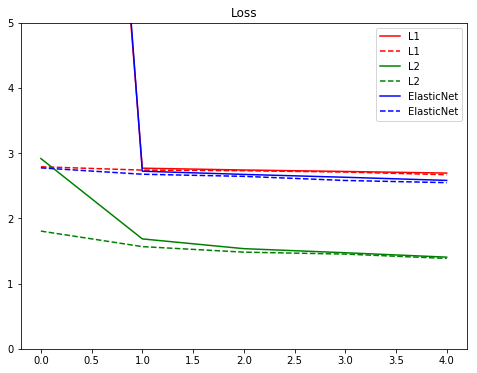

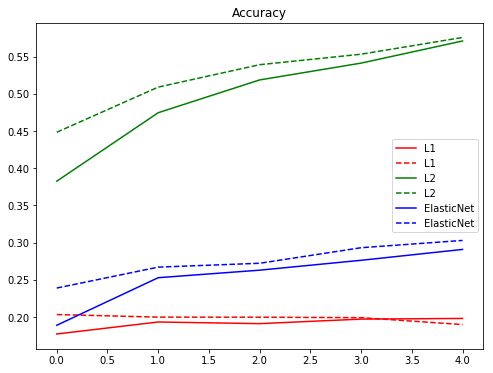

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()